# DSCI 592 Capstone II: Group Project
## Team: Safe CIty
## NY-Brooklyn  (Clustering)

In [1]:
# Common imports
import numpy as np
import pandas as pd
import seaborn as sns

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler
from sklearn.decomposition import PCA

# to make this notebook's output identical at every run
np.random.seed(42)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
# Import the data as Pandas DataFrame as follows
df = pd.read_csv("df_brook_zip_law.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FELONY       38 non-null     int64  
 1   MISDEMEANOR  38 non-null     int64  
 2   VIOLATION    38 non-null     int64  
 3   Crime        38 non-null     int64  
 4   zip          38 non-null     int64  
 5   latitude     38 non-null     float64
 6   longitude    38 non-null     float64
dtypes: float64(2), int64(5)
memory usage: 2.2 KB


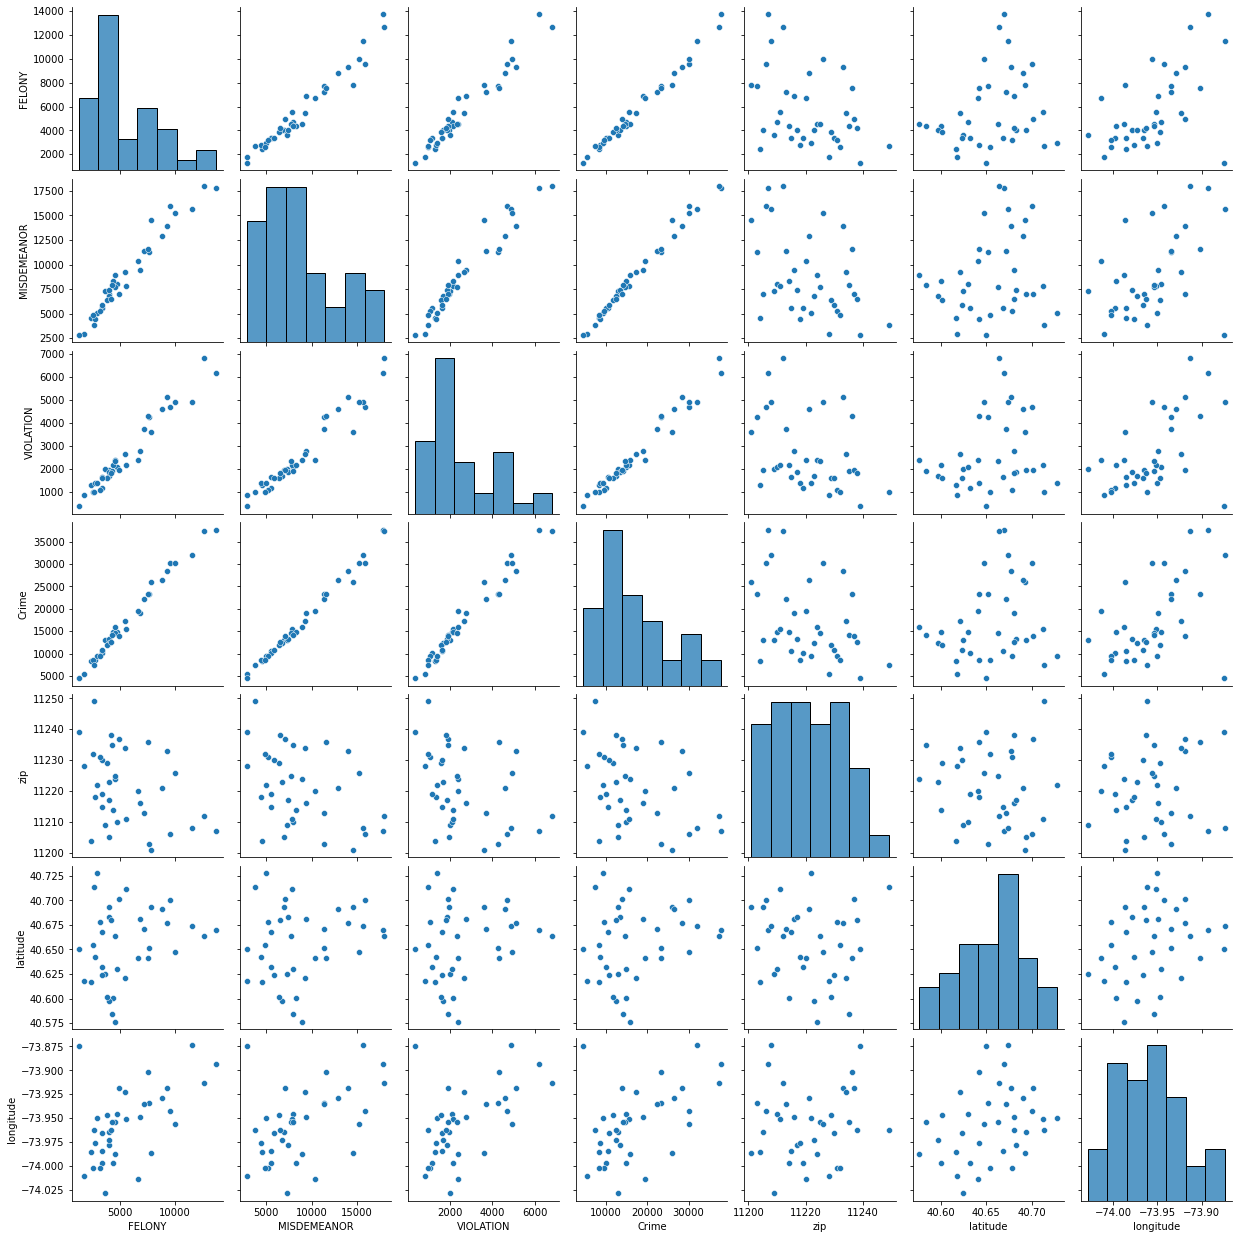

In [4]:
sns.pairplot(df)

## 1. K-Means

- Drop zip code column

In [5]:
df2 = df.copy()
df2.drop('zip', axis=1, inplace=True)
df2.head()

,FELONY,MISDEMEANOR,VIOLATION,Crime,latitude,longitude
0,7846,14551,3590,25987,40.693036,-73.986889
1,7685,11308,4242,23235,40.651822,-73.934689
2,2432,4540,1283,8255,40.616540,-73.985299
3,4021,7005,1944,12970,40.693346,-73.964849
4,9581,15920,4663,30164,40.700728,-73.942391


In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(df2)
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_scaled) for k in range(2, 7)]
inertias = [model.inertia_ for model in kmeans_per_k]

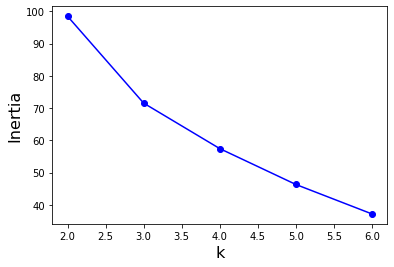

In [7]:
plt.figure(figsize=(6, 4))
plt.plot(range(2, 7), inertias, "bo-")
plt.xlabel("k", fontsize=16)
plt.ylabel("Inertia", fontsize=16)
plt.show()

- Hinge at k = 3

In [8]:
# Computation of silhouette sores
silhouette_scores = [silhouette_score(X_scaled, model.labels_) for model in kmeans_per_k]

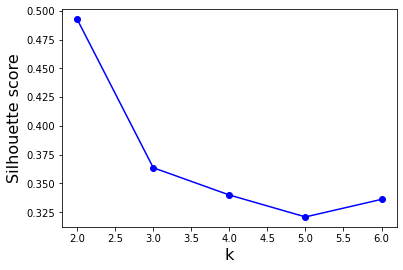

In [9]:
plt.figure(figsize=(6, 4))
plt.plot(range(2, 7), silhouette_scores, "bo-")
plt.xlabel("k", fontsize=16)
plt.ylabel("Silhouette score", fontsize=16)
plt.show()

## 3-cluster result

In [10]:
kmeans_3 = KMeans(n_clusters=3, random_state=42)
kmeans_3.fit(X_scaled)

KMeans(n_clusters=3, random_state=42)

In [11]:
cols = list(df2)  # make column name list
cols

['FELONY', 'MISDEMEANOR', 'VIOLATION', 'Crime', 'latitude', 'longitude']

In [12]:
# Scatter plot of 3-cluster result
# X_scaled: scaled X variables
# yr: cluster labels
# column name of X variables
# x: x-label to plot
# y: y-label to plot
def plot_3c(X_s, yr, cols, x, y):
    nx = cols.index(x)
    ny = cols.index(y)
    plt.scatter(X_s[:,nx][yr==2], X_s[:,ny][yr==2],
              marker='^', c = 'b', s = 80, alpha = 0.6)
    plt.scatter(X_s[:,nx][yr==1], X_s[:,ny][yr==1],
              marker='o', c = 'r', s = 70, alpha = 0.6)
    plt.scatter(X_s[:,nx][yr==0], X_s[:,ny][yr==0],
              marker='s', c = 'y', s = 50, alpha = 0.6)
    plt.xlabel(x,fontsize=14)
    plt.ylabel(y,fontsize=14)
    plt.legend(["C2","C1","C0"],fontsize=14)

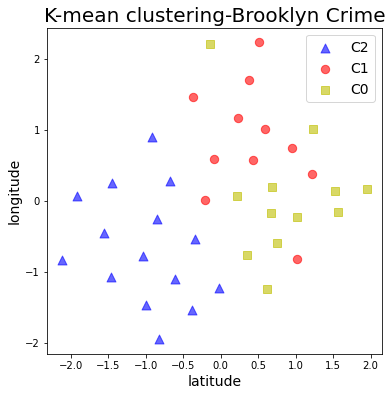

In [13]:
plt.figure(figsize=(6,6))
plot_3c(X_scaled, kmeans_3.labels_, cols, 'latitude', 'longitude')
plt.title('K-mean clustering-Brooklyn Crime', fontsize = 20)
plt.show()

### Cluster center

In [14]:
cols = list(df2)
kmeans_center_df = pd.DataFrame(kmeans_3.cluster_centers_, columns=cols)
kmeans_center_df

,FELONY,MISDEMEANOR,VIOLATION,Crime,latitude,longitude
0,-0.526498,-0.617469,-0.590771,-0.585590,0.871040,0.053424
1,1.341530,1.359462,1.405371,1.372343,0.425131,0.824590
2,-0.562590,-0.502964,-0.557989,-0.537913,-1.008595,-0.647438


In [15]:
table1 = df2.describe()
table1[:3]

,FELONY,MISDEMEANOR,VIOLATION,Crime,latitude,longitude
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,5563.210526,8811.552632,2613.421053,16988.184211,40.655199,-73.956523
std,3071.324216,4153.827722,1586.919021,8742.313321,0.037769,0.037738


### Scaled cluster center

In [16]:
# Scaled cluster center
kmeans_center_scale_df = kmeans_center_df.copy()
for i in cols:
    kmeans_center_scale_df[i] = kmeans_center_scale_df[i]*table1[i][2]+table1[i][1]
    
kmeans_center_scale_df = kmeans_center_scale_df.astype({"FELONY":int, "MISDEMEANOR": int, "VIOLATION":int, "Crime": int})
kmeans_center_scale_df["cluster"] = kmeans_center_scale_df.index
kmeans_center_scale_df

,FELONY,MISDEMEANOR,VIOLATION,Crime,latitude,longitude,cluster
0,3946,6246,1675,11868,40.688097,-73.954507,0
1,9683,14458,4843,28985,40.671256,-73.925405,1
2,3835,6722,1727,12285,40.617106,-73.980957,2


### Scaled cluster center/mean value

In [17]:
# Scaled cluster center (normalized by mean)
table1 = df2.describe()
cols = list(df2)
kmeans_center_ratio_df = kmeans_center_scale_df.copy()
for i in cols:
    kmeans_center_ratio_df[i] = (kmeans_center_df[i]*table1[i][2]+table1[i][1])/table1[i][1]

kmeans_center_ratio_df["cluster"] = kmeans_center_scale_df.index
kmeans_center_ratio_df

,FELONY,MISDEMEANOR,VIOLATION,Crime,latitude,longitude,cluster
0,0.709332,0.708921,0.641273,0.698649,1.000809,0.999973,0
1,1.740629,1.640860,1.853368,1.706224,1.000395,0.999579,1
2,0.689406,0.762899,0.661179,0.723184,0.999063,1.000330,2


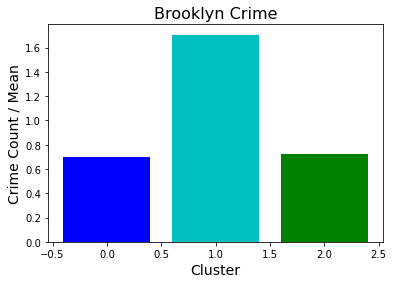

In [18]:
plt.figure(figsize=(6,4))
plt.bar(kmeans_center_ratio_df['cluster'],kmeans_center_ratio_df['Crime'],color=['b','c', 'g','r','y'])
plt.xlabel("Cluster",fontsize=14)
plt.ylabel("Crime Count / Mean",fontsize=14)
#plt.grid()
plt.title('Brooklyn Crime', fontsize = 16)
plt.show()

## Append 3 cluster result to the dataframe

In [19]:
label = kmeans_3.labels_

In [20]:
df.head(3)

,FELONY,MISDEMEANOR,VIOLATION,Crime,zip,latitude,longitude
0,7846,14551,3590,25987,11201,40.693036,-73.986889
1,7685,11308,4242,23235,11203,40.651822,-73.934689
2,2432,4540,1283,8255,11204,40.616540,-73.985299


In [21]:
df["K_mean"] = label

In [22]:
df.head()

,FELONY,MISDEMEANOR,VIOLATION,Crime,zip,latitude,longitude,K_mean
0,7846,14551,3590,25987,11201,40.693036,-73.986889,1
1,7685,11308,4242,23235,11203,40.651822,-73.934689,1
2,2432,4540,1283,8255,11204,40.616540,-73.985299,2
3,4021,7005,1944,12970,11205,40.693346,-73.964849,0
4,9581,15920,4663,30164,11206,40.700728,-73.942391,1


In [23]:
# Write to a csv file
df.to_csv("df_brook_k3.csv", index = False)

### Cluster-Zip code

In [24]:
df_select = df[['zip','K_mean']]
cluster_zip_list = [] 
for cluster in range(3):
    cluster_zip_list.append(
        (cluster, list(df_select[df['K_mean']==cluster]['zip'])))
cluster_zip_dict =  dict(cluster_zip_list)

In [25]:
for cluster in range(3):
    print(cluster, cluster_zip_dict[cluster])

0 [11205, 11211, 11215, 11216, 11217, 11222, 11225, 11231, 11237, 11238, 11239, 11249]
1 [11201, 11203, 11206, 11207, 11208, 11212, 11213, 11221, 11226, 11233, 11236]
2 [11204, 11209, 11210, 11214, 11218, 11219, 11220, 11223, 11224, 11228, 11229, 11230, 11232, 11234, 11235]


In [26]:
pd.DataFrame(cluster_zip_dict.items(),
            columns=['Cluster','Zip Code'])

,Cluster,Zip Code
0,0,"[11205, 11211, 11215, 11216, 11217, 11222, 112..."
1,1,"[11201, 11203, 11206, 11207, 11208, 11212, 112..."
2,2,"[11204, 11209, 11210, 11214, 11218, 11219, 112..."
